Note download data from https://drive.google.com/drive/folders/1EgDN57LDuvlZAwr5-eHWB5CTJ7K9HpDP

Credit to this repo: https://github.com/LukasMosser/geolink_dataset

## Data Disclaimer

All the data serving as an input to these notebooks was generously donated by GEOLINK  
and is CC-by-SA 4.0 

If you use their data please reference their dataset properly to give them credit for their contribution.

In [2]:
import lasio
import matplotlib.pyplot as plt
%matplotlib inline
import os
from tqdm.auto import tqdm
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path
from sklearn import preprocessing
from operator import itemgetter

ModuleNotFoundError: No module named 'lasio'

# in and our directories

In [3]:
data_locations = Path(
    "../../data/raw/geolink_dataset/GEOLINK North sea wells with Lithology interpretation/GEOLINK_Lithology and wells NORTH SEA"
)
data_locations_wellheads = Path("../../data/raw/geolink_dataset/norge_well_heads")
interim_locations = Path("../../data/processed/geolink_norge_dataset/")

NameError: name 'Path' is not defined

# load and save as parquet

In [ ]:
df_lithology = pd.read_excel(data_locations / "../Lithology code data.xlsx", header=1)[
    :-1
]
df_lithology["Abbreviation"] = pd.to_numeric(df_lithology["Abbreviation"])
df_lithology.to_parquet(
    interim_locations / "geolink_norge_lithology.parquet", compression="gzip"
)
df_lithology

In [ ]:
df_well_tops = pd.concat(
    [
        pd.read_csv(data_locations_wellheads / "wellbore_exploration_all.csv"),
        pd.read_csv(data_locations_wellheads / "wellbore_development_all.csv"),
        pd.read_csv(data_locations_wellheads / "wellbore_other_all.csv"),
    ]
)
df_well_tops["wlbWellboreName_geolink"] = df_well_tops["wlbWellboreName"].str.replace(
    "/", "_"
)


# add dates
date_cols = ["wlbEntryDate", "wlbCompletionDate"]
for c in date_cols:
    df_well_tops[c] = pd.to_datetime(df_well_tops[c])  # .astype('str')

df_well_tops["wlbNsDecDeg"] = df_well_tops["wlbNsDecDeg"].replace(0, np.nan)
df_well_tops["wlbEwDesDeg"] = df_well_tops["wlbEwDesDeg"].replace(0, np.nan)

a = set(df_well_tops.columns)
df_well_tops = df_well_tops.dropna(axis=1, thresh=0.9 * len(df_well_tops))
b = set(df_well_tops.columns)
print("removed", a - b)

# make into geodataframe
df_well_tops = gpd.GeoDataFrame(
    df_well_tops,
    geometry=gpd.points_from_xy(df_well_tops.wlbEwDesDeg, df_well_tops.wlbNsDecDeg),
)
df_well_tops

## Las files

We can now proceed to import these files as las files and get their dataframes and hopefully put them into a data format that is more suited for ML tasks.

In [ ]:
if not (interim_locations / "geolink_norge_well_logs_raw.parquet").exists():

    # load las files
    well_dataframes = []
    files = sorted(data_locations.glob("*.las"))
    for f in tqdm(files):
        df = lasio.read(f).df()
        df["Well"] = f.stem
        well_dataframes.append(df)

    df_all = pd.concat(well_dataframes)

    df_all["Well"] = df_all["Well"].astype("category")

    # Name lithology
    litho_dict = df_lithology.set_index("Abbreviation")["Lithology"].to_dict()
    df_all["LITHOLOGY_GEOLINK"] = (
        df_all["LITHOLOGY_GEOLINK"].replace(litho_dict).astype("category")
    )

    # unique index
    df_all = df_all.reset_index()  # .set_index(['Well', 'DEPT'])

    df_all.to_parquet(
        interim_locations / "geolink_norge_well_logs_raw.parquet", compression="gzip"
    )

df_all = pd.read_parquet(interim_locations / "geolink_norge_well_logs_raw.parquet")

## Clean las files

In [ ]:
# Clean.

# must have well head
df_all_clean2 = df_all[
    df_all.Well.apply(lambda s: s in set(df_well_tops["wlbWellboreName_geolink"]))
]

# must have lithology
df_all_clean2 = df_all_clean2.dropna(subset=["LITHOLOGY_GEOLINK"])
print("nans", df_all_clean2.isna().mean().sort_values())
# Remove logs which are present less than half the time
df_all_clean1 = df_all_clean2.dropna(axis=1, thresh=0.9 * len(df_all_clean2))
print('kept {:%} cols'.format(len(df_all_clean1.columns) / len(df_all_clean2.columns)))
# Drop columns with Nan's
df_all_clean = df_all_clean1.dropna(axis=0)
print('kept {:%} rows'.format(len(df_all_clean) / len(df_all_clean2)))
df_all_clean

In [ ]:
# Split by well name
wells_val = [
    "35_11-1",
    "35_11-10",
    "35_11-11",
    "35_11-12",
    "35_11-13",
    "35_11-15 S",
    "35_11-2",
    "35_11-5",
    "35_11-6",
    "35_11-7",
    "35_12-1",
]

wells_test = [
    "34_10-12",
    "34_10-16 R",
    "34_10-17",
    "34_10-19",
    "34_10-21",
    "34_10-23",
    "34_10-33",
    "34_10-35",
    "34_10-5",
    "34_10-7",
    "34_11-1",
    "34_11-2 S",
    "34_11-3 T2",
]

In [ ]:
df_all_clean_test = df_all_clean[df_all_clean.Well.apply(lambda s: s in wells_test)]
df_all_clean_train = df_all_clean[
    df_all_clean.Well.apply(lambda s: (s not in wells_test) and (s not in wells_val))
]
assert len(set(df_all_clean_val.Well).intersection(set(df_all_clean_train))) == 0
assert len(set(df_all_clean_test.Well).intersection(set(df_all_clean_train))) == 0
assert len(set(df_all_clean_test.Well).intersection(set(df_all_clean_val))) == 0
len(df_all_clean_train), len(df_all_clean_val), len(df_all_clean_test)

In [ ]:
df_all_clean_train.to_parquet(
    interim_locations / "geolink_norge_well_logs_train.parquet", compression="gzip"
)
df_all_clean_test.to_parquet(
    interim_locations / "geolink_norge_well_logs_test.parquet", compression="gzip"
)
df_all_clean_val.to_parquet(
    interim_locations / "geolink_norge_well_logs_val.parquet", compression="gzip"
)

In [ ]:
df_all_clean

# Others

In [ ]:
df_picks = pd.read_excel(
    data_locations / "../NPD stratigraphic picks north sea.xlsx", header=0
)
df_picks.to_parquet(
    interim_locations / "geolink_norge_picks.parquet", compression="gzip"
)

In [ ]:
df_picks

## Well heads part 2

In [ ]:
# only wells we use
a = sorted(df_all.Well.unique())
df_well_tops = df_well_tops[
    df_well_tops["wlbWellboreName_geolink"].apply(lambda s: s in a)
]

In [ ]:
df_well_tops.to_file(interim_locations / "norge_well_tops.gpkg", driver="GPKG")

# Example Load

In [ ]:
# Test load
df_all_clean2 = pd.read_parquet(
    interim_locations / "geolink_norge_well_logs_train.parquet"
)  # .set_index(['Well', 'DEPT'])

df_well_tops = gpd.read_file(interim_locations / "norge_well_tops.gpkg")
df_well_tops_minimal = df_well_tops[
    [
        "wlbWellboreName_geolink",
        "wlbCompletionYear",
        "wlbKellyBushElevation",
        "wlbCompletionDate",
        "wlbTotalDepth",
        "geometry",
    ]
]
df_well_tops.plot()

In [ ]:
# Merge well tops and well logs, a selection
df_all_clean3 = pd.merge(
    left=df_all_clean2.sample(1000),
    right=df_well_tops_minimal,
    left_on="Well",
    right_on="wlbWellboreName_geolink",
    how="left",
).drop(columns="wlbWellboreName_geolink")
df_all_clean3 = df_all_clean3.set_index(['Well', 'DEPT'])
df_all_clean3 = gpd.GeoDataFrame(df_all_clean3, geometry=df_all_clean3['geometry'])
df_all_clean3.plot()
# df_all_clean3

In [ ]:
df_picks = pd.read_parquet(interim_locations / "geolink_norge_picks.parquet")
df_picks

In [ ]:
df_all_clean = pd.read_parquet(
    interim_locations / "geolink_norge_well_logs_train.parquet"
).set_index(["Well", "DEPT"])
df_all_clean

# Example plot

In [ ]:
df_all_clean = pd.read_parquet(
    interim_locations / "geolink_norge_well_logs_train.parquet"
).set_index(["Well", "DEPT"])
df_all_clean['DEPT'] = df_all_clean.index.get_level_values(1)
df_all_clean

In [ ]:
from deep_ml_curriculum.visualization.well_log import plot_facies, plot_well
well_name="30_4-1"
logs = df_all_clean.xs(well_name)
facies = logs['LITHOLOGY_GEOLINK'].astype('category').values
plot_well(well_name, 
          logs, 
          facies)

In [ ]:
plt.figure(figsize=(1,8))
plot_facies(facies, plt.gca(), colorbar=False)

# reindex depth and to Xarray

This lets us includes location easily without using much more space

In [ ]:
# Load some
df_all_clean1 = pd.read_parquet(
    interim_locations / "geolink_norge_well_logs_test.parquet"
).set_index(['Well', 'DEPT'])
df_all_clean1['Depth'] = df_all_clean1.index.get_level_values(1)
df_all_clean1['split'] = 'test'

# Load some
df_all_clean2 = pd.read_parquet(
    interim_locations / "geolink_norge_well_logs_train.parquet"
).set_index(['Well', 'DEPT'])
df_all_clean2['Depth'] = df_all_clean2.index.get_level_values(1)
df_all_clean2['split'] = 'train'

# Load some
df_all_clean3 = pd.read_parquet(
    interim_locations / "geolink_norge_well_logs_val.parquet"
).set_index(['Well', 'DEPT'])
df_all_clean3['Depth'] = df_all_clean3.index.get_level_values(1)
df_all_clean3['split'] = 'val'

df_all = pd.concat([df_all_clean1, df_all_clean2, df_all_clean3])
df_all

In [ ]:
df_well_tops = gpd.read_file(interim_locations / "norge_well_tops.gpkg")
df_well_tops_minimal = df_well_tops[
    [
        "wlbWellboreName_geolink",
        "wlbCompletionYear",
        "wlbKellyBushElevation",
        "wlbCompletionDate",
        "wlbTotalDepth",
        "geometry",
    ]
].copy()
df_well_tops_minimal['xc'] = df_well_tops_minimal.geometry.x
df_well_tops_minimal['yc'] = df_well_tops_minimal.geometry.y
df_well_tops_minimal

In [ ]:
nidx = np.arange(0, 6000, 0.15)

In [ ]:
def reindex(x):
    """Reindex each well to 15cm"""
    x = x.reset_index().set_index('DEPT')
    x = x.reindex(nidx, method='nearest', limit=1).drop(columns=['Well']).sort_index()
    return x
#     return x.reset_index().set_index(['Well', 'DEPT'])

df_all3 = df_all.groupby(level=0).apply(reindex).dropna()
df_all3

In [ ]:
import xarray as xr
xr_all_clean2 = df_all3.to_xarray()
xr_all_clean2

In [ ]:
xr_wells = df_well_tops_minimal.rename(columns={'wlbWellboreName_geolink':'Well'}).set_index('Well').to_xarray()
xr_wells

In [ ]:
xr_all = xr.merge(
    [xr_all_clean2, xr_wells],
    join='left')

In [ ]:
xr_all2 = xr_all.sortby(['Well', 'DEPT'])
xr_all2

In [ ]:
%reload_ext autoreload
%autoreload 2
from deep_ml_curriculum.visualization.well_log import plot_well

In [ ]:
well_name="30_4-1"
logs = xr_all2.sel(Well=well_name).to_dataframe().dropna()
logs['DEPT'] = logs['Depth']
facies = logs['LITHOLOGY_GEOLINK'].astype('category').values
plot_well(well_name, logs, facies)
logs

In [ ]:
from deep_ml_curriculum.visualization.well_log import plot_facies, plot_well
well_name="30_4-1"
logs = df_all_clean.xs(well_name)
facies = logs['LITHOLOGY_GEOLINK'].astype('category').values
plot_well(well_name, 
          logs, 
          facies)
logs

In [ ]:
def dset_to_nc(dset, f, engine="netcdf4", compression={"zlib": True}):
    if isinstance(dset, xr.DataArray):
        dset = dset.to_dataset(name="data")
    encoding = {k: {"zlib": True} for k in dset.data_vars}
    print('saving to {}'.format(f))
    dset.to_netcdf(f, engine=engine, encoding=encoding)
    print('Wrote {}.nc size={} M'.format(f.stem, f.stat().st_size / 1000000.0))

In [ ]:
dset_to_nc(dset=xr_all.drop(['geometry']),
          f=interim_locations/'geolink_norge_well_logs.h5')

In [ ]:
import os, shutil

def get_dir_size(start_path="."):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size

def dset_to_zarr(dset, f):
    if isinstance(dset, xr.DataArray):
        dset = dset.to_dataset(name="data")
    encoding = {k: {"zlib": True} for k in dset.data_vars}
    print('saving to {}'.format(f))
    if f.exists():
        try:
            return xr.open_zarr(f)
        except:
            shutil.rmtree(f)
    dset.to_zarr(str(f))
    print('{}.zarr size={} M'.format(f.stem, get_dir_size(str(f)) / 1000000.0))
    
dset_to_zarr(dset=xr_all.drop(['geometry']),
          f=interim_locations/'geolink_norge_well_logs.zarr')

# Plot map

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
from tqdm.auto import tqdm
import pandas as pd
import geopandas as gpd
import numpy as np

In [177]:
# import pandas as pd
# import xarray as xr
# xf = xr.open_zarr("../../data/processed/geolink_norge_dataset/geolink_norge_well_logs.zarr")
# df = xf.to_dataframe().swaplevel().sample(1000)
# df['LITHOLOGY_GEOLINK'] = df['LITHOLOGY_GEOLINK'].astype('category')
# df['Well'] = df.index.get_level_values(0).astype('category')
# df['DEPT'] = df.index.get_level_values(1)
# feature_cols = ['CALI', 'DTC', 'GR', 'RDEP', 'RHOB',
#        'RMED', 'xc', 'yc', 'DEPT']
# df = df.dropna(how='any', subset=feature_cols+['LITHOLOGY_GEOLINK'])
# df = df.sort_index()

# import geopandas as gpd
# gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.xc, df.yc))
# gdf = gdf.set_crs(epsg=4326).to_crs(epsg=3857)
# gdf.plot()

# Plot contextily

In [67]:
from pathlib import Path
interim_locations = Path("../../data/processed/geolink_norge_dataset/")
df_well_tops = gpd.read_file(interim_locations / "norge_well_tops.gpkg").set_crs(epsg=4326).to_crs(epsg=3857)#.head(40)
# df_well_tops.plot()

/home/wassname/anaconda/envs/deep_ml_curriculum/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/wassname/anaconda/envs/deep_ml_curriculum/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


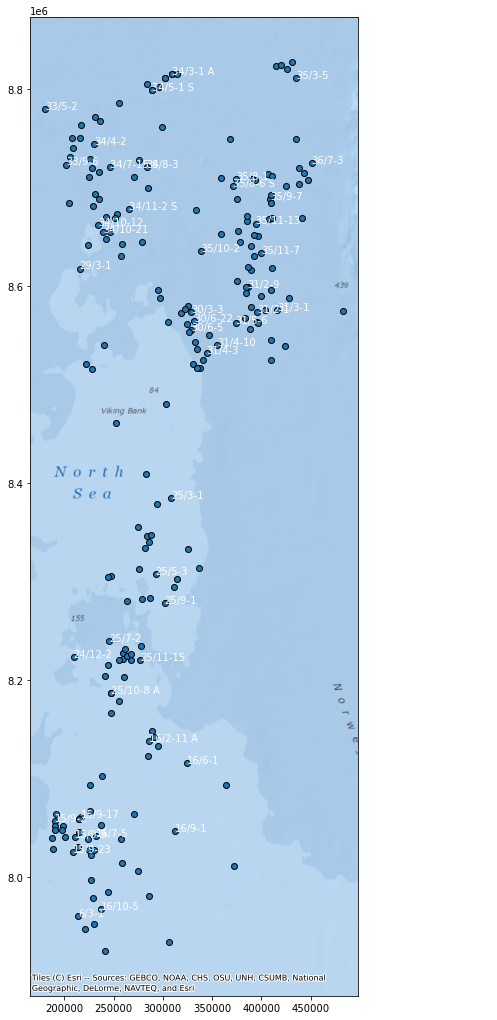

In [183]:


import contextily as ctx
ax = df_well_tops.plot(figsize=(18, 18), edgecolor='k')
ctx.add_basemap(ax, url=ctx.providers.Esri.OceanBasemap)

# Plot every 5th
df_well_tops[::5].apply(lambda x: 
                   ax.annotate(
                       s=x.wlbWellboreName, 
                       xy=x.geometry.centroid.coords[0], 
                       ha='left',
                       c='white'
                   ), axis=1);